In [58]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf

from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Conv2D, Reshape
from keras.layers import concatenate
from keras.layers.normalization import BatchNormalization
from keras.layers.core import Dropout, Activation
from keras.optimizers import Adadelta, Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import backend as K
from keras.preprocessing.image import load_img,img_to_array
import cv2

In [2]:
# Set some parameters
im_width = 128
im_height = 128
border = 5
train_img=[]
train_mask=[]

In [3]:
train = open("../VOC_2011_TrainVal/VOCdevkit/VOC2011/ImageSets/Segmentation/train_2.txt", 'r')
lines = train.readlines()
for i, line in enumerate(lines):
    train_img.append("../VOC_2011_TrainVal/VOCdevkit/VOC2011/JPEGImages/"+line.split('\n')[0]+".jpg")
    train_mask.append("../VOC_2011_TrainVal/VOCdevkit/VOC2011/SegmentationClass/"+line.split('\n')[0]+".png")
train.close()

In [4]:
a =cv2.imread(train_img[0])
a.shape

(281, 500, 3)

In [13]:
# Get and resize train images and masks
def get_data(img_path_list, mask_path_list, train=True):
    X = np.zeros((len(img_path_list), im_height, im_width, 3), dtype=np.float32)
    if train:
        y = np.zeros((len(img_path_list), im_height, im_width, 3), dtype=np.float32)
    print('Getting and resizing images ... ')
    for n, img in tqdm_notebook(enumerate(img_path_list), total=len(img_path_list)):
        # Load images
        img = load_img(img)
        x_img = img_to_array(img)
        x_img = resize(x_img, (128, 128), mode='constant', preserve_range=True)

        # Load masks
        if train:
            mask = img_to_array(load_img(mask_path_list[n]))
            mask = resize(mask, (128, 128), mode='constant', preserve_range=True)

        # Save images
        #X[n, ..., 0] = x_img.squeeze() / 255.0
        X[n] = x_img / 255.0
        if train:
            y[n] = mask / 255.0
    print('Done!')
    if train:
        return X, y
    else:
        return X
    
X, y = get_data(train_img, train_mask, train=True)

Getting and resizing images ... 



Done!


In [47]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.15, random_state=2020)

In [14]:
X.shape, y.shape

((124, 128, 128, 3), (124, 128, 128, 3))

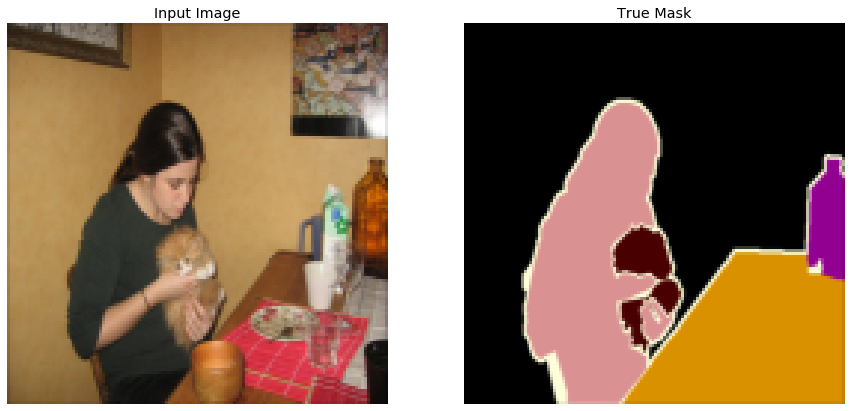

In [73]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

    

display([X_train[10], y_train[10]])

In [105]:
n_classes=20

img_input = Input(shape=(im_height, im_width, 3))

conv1=Conv2D(32, (3,3), activation='relu', padding='same')(img_input)
conv1=Dropout(0.2)(conv1)
conv1=Conv2D(32, (3,3), activation='relu', padding='same')(conv1)
pool1=MaxPooling2D((2,2))(conv1)

conv2=Conv2D(64, (3,3), activation='relu', padding='same')(pool1)
conv2=Dropout(0.2)(conv2)
conv2=Conv2D(64, (3,3), activation='relu', padding='same')(conv2)
pool2=MaxPooling2D((2,2))(conv2)

conv3=Conv2D(128, (3,3), activation='relu', padding='same')(pool2)
conv3=Dropout(0.2)(conv3)
conv3=Conv2D(128, (3,3), activation='relu', padding='same')(conv3)

up1=concatenate([UpSampling2D((2,2))(conv3), conv2], axis=-1)
conv4=Conv2D(64, (3,3), activation='relu', padding='same')(up1)
conv4=Dropout(0.2)(conv4)
conv4=Conv2D(64, (3,3), activation='relu', padding='same')(conv4)

up2=concatenate([UpSampling2D((2,2))(conv4), conv1], axis=-1)
conv5=Conv2D(32, (3,3), activation='relu', padding='same')(up2)
conv5=Dropout(0.2)(conv5)
conv5=Conv2D(32, (3,3), activation='relu', padding='same')(conv5)

out=Conv2D(3, (1,1), padding='same')(conv5)

In [106]:

model = Model(img_input, out)
model.compile(optimizer=Adam(), loss='binary_crossentropy')

In [117]:
model.summary()

Model: "model_17"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv2d_302 (Conv2D)             (None, 128, 128, 32) 896         input_17[0][0]                   
__________________________________________________________________________________________________
dropout_16 (Dropout)            (None, 128, 128, 32) 0           conv2d_302[0][0]                 
__________________________________________________________________________________________________
conv2d_303 (Conv2D)             (None, 128, 128, 32) 9248        dropout_16[0][0]                 
___________________________________________________________________________________________

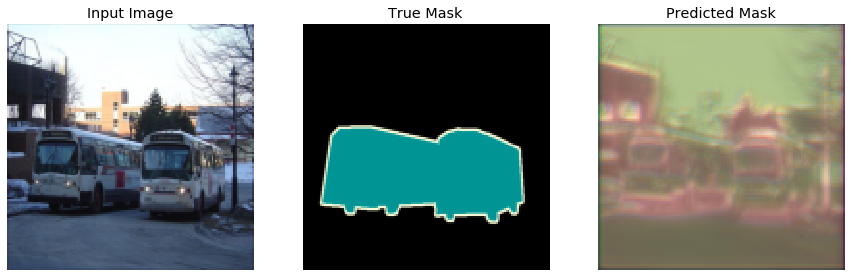

In [127]:
display([X_train[0], y_train[0],model.predict(X_train[0].reshape(1,128,128,3)).reshape(128,128,3)*255.0])

In [109]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions()
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [111]:
EPOCHS = 5
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = len(X_train) // BATCH_SIZE

model_history = model.fit(X_train, y_train,  epochs=EPOCHS)

Epoch 1/5
105/105 [==============================] - ETA: 29s - loss: 0.50 - ETA: 17s - loss: 0.47 - ETA: 3s - loss: 0.4584 - 36s 346ms/step - loss: 0.4593
Epoch 2/5
105/105 [==============================] - ETA: 14s - loss: 0.40 - ETA: 9s - loss: 0.3880 - ETA: 2s - loss: 0.398 - 24s 232ms/step - loss: 0.4087
Epoch 3/5
105/105 [==============================] - ETA: 16s - loss: 0.46 - ETA: 9s - loss: 0.4059 - ETA: 2s - loss: 0.409 - 25s 242ms/step - loss: 0.4007
Epoch 4/5
105/105 [==============================] - ETA: 16s - loss: 0.39 - ETA: 8s - loss: 0.3906 - ETA: 1s - loss: 0.399 - 22s 209ms/step - loss: 0.3927
Epoch 5/5
105/105 [==============================] - ETA: 17s - loss: 0.38 - ETA: 9s - loss: 0.3927 - ETA: 2s - loss: 0.382 - 24s 232ms/step - loss: 0.3846


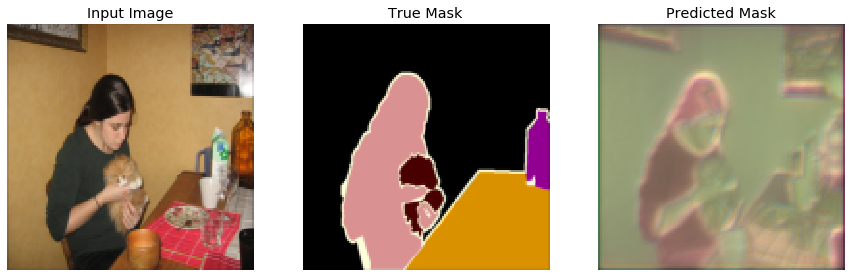

In [126]:
i=10
display([X_train[i], y_train[i],model.predict(X_train[i].reshape(1,128,128,3)).reshape(128,128,3)*255.0])

In [55]:
def segnet(input_img, n_classes):
    
    x = BatchNormalization()(input_img)
    
    # Block 1
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)

    # Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)

    # Block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)

    # Block 4
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)

    # Block 5
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)
    
    # Up Block 1
    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    
    # Up Block 2
    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    
    # Up Block 3
    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    
    # Up Block 4
    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    
    # Up Block 5
    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    
    x = Conv2D(1, (1, 1), activation='linear', padding='same')(x)
    
    model = Model(inputs=[input_img], outputs=[x])
    return model

In [62]:
input_img = Input((im_height, im_width, 3), name='img')


model = segnet(input_img, n_classes=20)

model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img (InputLayer)             (None, 128, 128, 3)       0         
_________________________________________________________________
batch_normalization_11 (Batc (None, 128, 128, 3)       12        
_________________________________________________________________
conv2d_264 (Conv2D)          (None, 128, 128, 64)      1792      
_________________________________________________________________
conv2d_265 (Conv2D)          (None, 128, 128, 64)      36928     
_________________________________________________________________
max_pooling2d_50 (MaxPooling (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_266 (Conv2D)          (None, 64, 64, 128)       73856     
_________________________________________________________________
conv2d_267 (Conv2D)          (None, 64, 64, 128)       147

In [ ]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-tgs-salt.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

results = model.fit(X_train, y_train, batch_size=32, epochs=100, callbacks=callbacks,
                    validation_data=(X_valid, y_valid))

Train on 105 samples, validate on 19 samples
Epoch 1/100
 64/105 [=================>............] - ETA: 36s - loss: 0.37 - ETA: 19s - loss: 0.3601

In [68]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

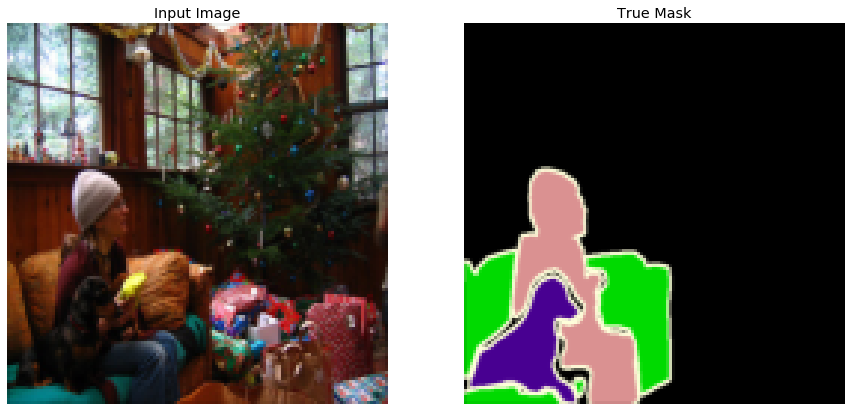